# Marine Particle Aggregation - A Discretized Mass Approach For The Smoluchowksi Coagulation Equation.

## Trivik Ragha

## Masters of Operational Oceanography 

### Rutgers University New Brunswick, New Jersey

### Department of Marine and Coastal Sciences

#### 2024


## Background


### Introduction
The basis of modelling particle aggregation in this notebook is the continuous and deterministic Smoluchowski Coagulation Equation (SCE). This is an integrodifferential equation that aims to capture the change in the Particle Size Distribution (PSD) over time strictly due to coagulation processes. The inspiration for this numerical model comes from the literature that Adrian B. Burd and George A. Jackson published in the Annual Review of Marine Science Journal in 2009 detailing the physics and mathematics of particle aggregation. $^{[1]}$.


### Particle Cluster Sizes
 The premise of the SCE is that two arbitrary particles of size r and s can come together and form an aggregate cluster of size r + s. $$C_r + C_s \rightarrow C_{r+s}.$$ Since mass is additive, this notebook will use mass as the particle size property. Note that this is a one way process, indicated by the unidirection arrow in the forward direction. A bidirectional arrow would indicate that the reverse direction is feasable due to fragmentation processes, which is not modelled in this notebook.

For the sake of simplicity, this model assumes all particles are perfect spheres with uniform density. In reality though, marine particles and aggregates are more often that not non-spherical, and have a certain degree of porosity. Using experimental data, it is possible to map the mass of a particle/aggregate to its equivalent radius by means of a fractal dimension - which gives a measure of how the particles scale in the spatial dimension with respect to mass. In general this mass-radius relationship is as follows: $$m \propto r^{D_f}.$$

For spherical particles with uniform density, the fractal dimension, $D_{f}$, is equal to 3. Hence: $$m \propto r^3.$$ Using the standard equations of density and volume of a sphere, the eqaution that maps the particles mass to its radius is given by: $$m = \rho \times \frac{4}{3} \times \pi \times r^3. \ (1)$$
Equation (1) will be used in this notebook between for mass-radius and radius-mass conversions. The standard units used in the model for mass, density and radius are grams, grams per cubic centimeter and centimeter respectively.


### The Particle Size Spectrum and Cluster Concentrations
The Particle Size Spectrum (PSD) is a distribution of particles of a given size and their repsective concentrations at a given point in time. It is most common to use a number concentration in number of particles per cubic centimeter, which is what this model uses. The PSD can be visualized for a specific time by a plot of number concentrations on the vertical axis against the corresponding particle sizes on the vertical axis. Because it is much easier to guage the the sizes on a spatial scale, the PSD plots in this model have the corresponding particle diameters on the horizontal axis instead of particle masses. 

The Cluster Concentration, denoted $C(m,t)$, is a function of particle size (mass) and time. This is a bivariate mapping of the cartesian product of the Mass domain, $M \subseteq \mathbb{R^{+}}$ and the Time domain $T \subseteq \mathbb{R^{+}}$, to the Number Concentration codomain $C \subseteq \mathbb{R^{+}}$.

In theory, the mass domain is a continuous subset of the positive real numbers - which is uncountably infinite. However, for compuational feasability, the model uses a discretized approach of point masses spaced out accordingly into a finite set/array across a the mass domain.


### The Coagualtion Kernels
The Coagulation Kernels are rate functions that quantify the different physical mechanisms in two particles that can coalesce. These rate functions are bivariate nonlinear mappings that take two masses from the mass domain and map them to a codomain of volumetric rates. In this model, the coagulation kernels calculate the volumetric rates in cubic centimeters per second. The three main physical phenomena that play a key role in marine particle aggregation are:

1. Brownian Motion, $\beta_{Br}: \mathbb{R^{+}} \times \mathbb{R^{+}} \rightarrow \mathbb{R^{+}}$.

    Brownian motion refers to the random motion of particles suspended in a fluid (liquid or gas) resulting from their collision with the fast atoms or molecules in the gas or liquid. This erratic motion is caused by the kinetic energy of the surrounding molecules. This mapping aims to capture the dependence of collision rates on temperature, viscosity, and the masses of the interacting particles.

2. Fluid Shear, $\beta_{sh}: \mathbb{R^{+}} \times \mathbb{R^{+}} \rightarrow \mathbb{R^{+}}$.

    The fluid shear kernel describes the coagulation rate of two particles due to the shear induced by fluid motions. It is considered as the combined effect of laminar and turbulent shear.

    Laminar shear refers to the orderly movement of fluid particles in parallel layers, with each layer moving smoothly past its neighboring layers. When particles are subjected to laminar shear, they might come closer and coagulate due to the differential velocities in the fluid layers. The laminar shear mapping aims to capture the dependence of collision rates on the shear gradient and the masses of the interacting particles.

    Turbulence refers to a chaotic, erratic fluid motion characterized by eddies, swirls, and other instabilities. In turbulent flow, the random and high-energy movements of the fluid can force particles to collide and coagulate. Kinematic viscosity and turblent energy dissipation rates along the particle sizes play a crucial row on the collision rates of this mapping.

3. Differential Sedimentation, $\beta_{ds}: \mathbb{R^{+}} \times \mathbb{R^{+}} \rightarrow \mathbb{R^{+}}$.

    Differential sedimentation refers to the settling of particles in a fluid at different rates, typically due to differences in size or density. Larger or denser particles settle faster than smaller or less dense ones. When particles settle at different velocities, they can collide and coalesce. Collision rates are dependent on particles masses as well as their densities and the gravitational acceleration of the system. 

This model gives the option to investigate the effects of an individual kernel on aggregation, or the combined effect of all kernels of aggregation. 

The exact mathematical expressions of these kernels is given later on in the notebook. They are also found in the Burd and Jackson literature cited, but in radius form. To get the mass form of the kernels, equation (1) is used in conjunction with the kernels provided in the literature.

There are some important properties that coagulation kernels, $\beta(m_i,m_j)$, must have $^{[2]}$. These are:

(K1) $\beta$ must be continuous over all ordered pairs in the mass domain. Mathematically, $\beta \in C^0 (\mathbb{R^+} \times \mathbb{R^+})$.

(K2) $\beta$ must be non-negative. That is, $\beta(m_i,m_j) \geq 0, \ \forall (m_i,m_j) \in (\mathbb{R^+} \times \mathbb{R^+})$.

(K3) $\beta$ must be symmetric. That is, $\beta(m_i,m_j) = \beta(m_j,m_i), \ \forall (m_i,m_j) \in (\mathbb{R^+} \times \mathbb{R^+})$.

### The Smoluchowski Coagulation Equation

$$\frac{dC(m,t)}{dt} = \frac{\alpha}{2} \int \limits_{0}^{m} \beta(m_j,m-m_j)C(m-m_j,t)C(m_j,t)dm_j 
-\alpha C(m,t) \int \limits_{0}^{\infty} \beta(m,m_j)C(m_j,t)dm_j -C(m,t) \frac{w_s(s)}{Z} + I(m,t). \ (2)$$

Equation (2), read from left to right, describes the rate of change over time of the number of concentrations of clusters with a particular mass size $m$ in a given volume. This rate is equal to the net gain in mass concentration due to the coalescence of smaller particles forming mass $m$ minus the loss in mass concentration due to these $m$ mass clusters merging into larger particles, minus the loss in number concentration due to sedimentation, plus any external source or sink terms influencing the mass concentration. The parameter $\alpha$ in the equation is known as particle stickiness, and can be determined experimentally. Its interpretation serves as a quantification of two arbitrary particles aggregating together to form a cluster. $$\alpha = \frac{\text{adhesion rate}}{\text{collision rate}}.$$

1.  The Coagulation Gain Term:
    $$\frac{\alpha}{2} \int \limits_{0}^{m} \beta(m_j,m-m_j)C(m-m_j,t)C(m_j,t)dm_j.$$

    This expression captures the gain in mass concentrations of clusters of size $m$. The term considers all possible ways that smaller clusters can combine to form a cluster of mass $m$. The integral sums the contributions from all pairs of clusters $m_j$ and $m - m_j$ where $m_j$ ranges from zero to $m$. This accounts for every combination of smaller clusters whose total mass equals $m$ effectively covering all scenarios where two smaller clusters coalesce to form a cluster of the desired size.



2. The Coagulation Loss Term:
    $$-\alpha C(m,t) \int \limits_{0}^{\infty} \beta(m,m_j)C(m_j,t)dm_j.$$

    This expression captures the loss in mass concentration of clusters of size $m$ due to their participation in the formation of larger clusters. The term accounts for all possible instances where a cluster of mass $m$ merges with another cluster of any mass $m_j$. The integral spans over all possible masses $m_j$ in the mass domain, or in full form, from zero to infinity - because there is no limit placed on the size of the aggregate cluster, ensuring that every potential combination is considered.

3. The Sedimentation Term:
    $$-C(m,t) \frac{w_s(s)}{Z}.$$
    This expression accounts for the loss in mass concentration of clusters of size $m$ due to sedimentation. Sedimentation is a process where particles settle out of a fluid medium due to gravity or other forces. The rate at which a cluster sediments is given by $w_s(s)$, which is a function of the size $s$ of the cluster, often related to its mass $m$. The term $\frac{w_s(s)}{Z}$ normalizes this sedimentation rate over the depth or volume $Z$ of the system, reflecting the distribution of the sedimentation effect throughout the medium. The product of this rate with the concentration $C(m, t)$ gives the rate at which clusters of mass $m$ are lost from the suspension due to settling. This term thus captures the direct reduction in the number concentration of these clusters within the given volume due to sedimentation.


4. The Source term: 
    $$I(m,t).$$

    This term, $I(m,t)$, represents external influences on the mass concentration of clusters with mass $m$. These influences can include sources where clusters are being added to the system, such as through external injections or production processes, and sinks where clusters are being removed from the system, such as through chemical reactions or mechanical extraction. The function $I(m,t)$ quantifies these additions and removals as a function of mass and time, explicitly accounting for any external processes that alter the number concentration of clusters within the specified volume and time period.


### References
[1] Burd, A. B., & Jackson, G. A. (2009). Particle aggregation. Annual Review of Marine Science, 1(1), 65–90. https://doi.org/10.1146/annurev.marine.010908.163904.

[2] Islam, Md. S., Kimura, M., & Miyata, H. (2023). Generalized moment method for smoluchowski coagulation equation and mass conservation property. Mathematics, 11(12), 2770. https://doi.org/10.3390/math11122770.

## Numerical Model

### Imports

In [3]:
#Importing the necessary libraries
import pandas as pd
import numpy as np
import itertools
from scipy.interpolate import interp1d
from scipy.interpolate import PchipInterpolator
from scipy import integrate
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
from scipy.stats import norm
import seaborn as sns

np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 100000)

### Defining The Parameters

In [4]:
#Control Volume / Sample Parameters

Sample_Volume = 25 #Size of the Sample Container in the LISST 200X in mL which is equivalent cubic centimeters.
mld = 100  # Mixed Layer Depth/Fluid Thickness, Units: cm

#Kernel Function Parameters.

K_B = 1.381e-23  # Boltzmann Constant, Units: J/K
T_Celcius = 20  # Input Temperature in Celcius
T_th = T_Celcius + 273.15   # Thermodynamic Temperature, Units: K
rho_f = 1.025  # Fluid Density, Units: g/cm^3, Note: Dependent on Thermodynamic Temperature
rho_p = 1.200  # Diatom/Cocolithospheres  # Particle Density, Units: g/cm^3 #balance between biological/chemical factors.
mu = 10**-3 # To be set  # Dynamic Viscosity, Units: kg/(m*s), Note: Dependent on Thermodynamic Temperature
nu = mu/(rho_f *1000) # To be set  # Kinematic Viscosity, Units: m^2/s, Note: Dependent on Thermodynamic Temperature
gamma = 1  # Shear Gradient, Units: 1/s
epsilon = 10**-6 # Turbulent Energy Dissipation Rate, Units: m^2/s^3
a_g = 9.81  # Acceleration Due to Gravity, Units: m/s^2

#Coagulation Solver Parameters

alpha = 1 # Probability of Coagulation, Units: Dimensionless
Kernel = 'all' # Coagulation Kernel Type: 'all' for all kernels, 'br' for Brownian, 'ls' for laminar shear, 'ts' for turbulent shear,'fs' for total Fluid Shear, 'ds' for Total differential settling.
Type = 'rec' #Coagulation Kenrel type: 'rec' for Rectilinear, 'cur' for Curvilinear.
t_span = (0, 3600) # Time span for the simulation (start and end time) in seconds.
set_time_step = False # True for manual time steping, False for automatic time steping.
dt = 0.1  # Time step for the simulation in seconds for manual time stepping.
include_settling =  False # True to include settling in the model, False to exclude settling in the model.

### Defining The Cluster Size Functions

In [5]:
def mass2diameter(mass):
    "Mass in grams, diameter in cm"
    return ((6 / (np.pi * rho_p)) * mass) ** (1/3)

def diameter2mass(diameter):
    "Diameters in cm, mass in grams"
    return  (1/6) * np.pi * rho_p * (diameter**3)

### Defining Generating Functions for Particle Diameters and Respective Mass Domain

In [6]:
#Defining the diameter generating function
def generate_diameters(n, d_min, d_max, units):
    "Generate n diameters between d_min and d_max"
    if units == 'um':
        return np.linspace(d_min, d_max, n) * 10**-4 #Converting micrometers to centimeters
    elif units == 'cm':
        return np.linspace(d_min, d_max, n)
    
#Creating The mass domain function
def generate_mass_domain(diameters):
    "Generate n masses between d_min and d_max"
    "Units of diameters in cm, mass in grams"
    return diameter2mass(diameters)

### Defining the Coagulation Kernels

These are the coagulation Kernels:

$$K1 = \frac{3}{4}\frac{1}{\pi\ \rho_p}$$ 
$$K2 = \frac{\rho_p-\rho_f}{\mu}$$
$$P = \frac{\min\left(m_i^{\frac{1}{3}}, m_j^{\frac{1}{3}}\right)}{\max\left(m_i^{\frac{1}{3}}, m_j^{\frac{1}{3}}\right)}$$


The Brownian Motion Kernel:

$$\beta_{br}\left(m_i,m_j\right)=\frac{2}{3} \times 10^{6} \times \frac{K_BT_{th}}{\mu} \frac{\left(m_i^{\frac{1}{3}}+m_j^{\frac{1}{3}}\right)^2}{\left(m_im_j\right)^\frac{1}{3}}.$$

The Laminar Shear Rectilinear Kernel:

$$\beta_{ls,r}\left(m_i,m_j\right)=\frac{4}{3}\gamma K1 \left(m_i^{\frac{1}{3}}+m_j^{\frac{1}{3}}\right)^3.$$

The Turbulent Shear Rectilinear Kernel:

$$\beta_{ts,r}\left(m_i,m_j\right)=1.3\left(\frac{\epsilon}{\nu}\right)^{0.5} K1 \left(m_i^{\frac{1}{3}}+m_j^{\frac{1}{3}}\right)^3.$$

The Turbulent Shear Curvilinear Kernel:

$$\beta_{ts,c}\left(m_i,m_j\right)=9.8\frac{P^2}{1+2P^2}\left(\frac{\epsilon}{\nu}\right)^{0.5} K1 \left(m_i^{\frac{1}{3}}+m_j^{\frac{1}{3}}\right)^3.$$

The Differential Settling Rectilinear Kernel call this ds_r:

$$\beta_{ds,r}\left(m_i,m_j\right)=\frac{20}{9}\pi a_gK2K1^\frac{4}{3}\left(m_i^{\frac{1}{3}}+m_j^{\frac{1}{3}}\right)^2\left|m_j^{\frac{2}{3}}-m_i^{\frac{2}{3}}\right|.$$

The Differential Settling Curvilinear Kernel:

$$\beta_{ds,c}\left(m_i,m_j\right)=\frac{10}{9}\pi a_gK2K1^\frac{4}{3}{\ m}_i^{\frac{2}{3}}\left|m_i^{\frac{2}{3}}-m_j^{\frac{2}{3}}\right|.$$


In [18]:
# Define K1, K2, and P
K1 = (3 / 4) / (np.pi * rho_p)
K2 = (rho_p - rho_f) / mu

def P(mi, mj):
    return min(mi**(1/3), mj**(1/3)) / max(mi**(1/3), mj**(1/3))

def Settling_Velocity(m):
    return (20/9) * a_g * K1**(2/3) * K2 * m**(2/3)

# Coagulation Kernels
def b_br(mi, mj):
    """Brownian Motion Kernel"""
    return ((2 * 10**6)/ 3) * (K_B * T_th / mu) * ((mi**(1/3) + mj**(1/3))**2) / ((mi * mj)**(1/3))

def ls_r(mi, mj):
    """Laminar Shear Rectilinear Kernel"""

    return (4 / 3) * gamma * K1 * ((mi**(1/3) + mj**(1/3))**3)

def ts_r(mi, mj):
    """Turbulent Shear Rectilinear Kernel"""
    return 1.3 * 10**-12 * ((epsilon / nu)**0.5) * K1 * ((mi**(1/3) + mj**(1/3))**3)

def ts_c(mi, mj):
    """Turbulent Shear Curvilinear Kernel"""
    p = P(mi, mj)
    return 9.8 * (p**2 / (1 + 2 * p**2)) * ((epsilon / nu)**0.5) * K1 * ((mi**(1/3) + mj**(1/3))**3)

def ds_r(mi, mj):
    """Differential Settling Rectilinear Kernel"""
    return (20/ 9) * np.pi * a_g * K2 * K1**(4/3) * ((mi**(1/3) + mj**(1/3))**2) * abs(mj**(2/3) - mi**(2/3))

def ds_c(mi, mj):
    """Differential Settling Curvilinear Kernel"""
    return (10 / 9) * np.pi * a_g * K2 * K1**(4/3) * mi**(2/3) * abs(mi**(2/3) - mj**(2/3))

# Main Kernel Function
def beta(mi, mj, Kernel, Type):
    """Main Kernel Function to Determine Coagulation Kernel Based on Type and Kernel"""
    if Kernel == "all":
        if Type == "rec":
            return b_br(mi, mj) + ls_r(mi, mj) + ts_r(mi, mj) + ds_r(mi, mj)
        elif Type == "cur":
            return b_br(mi, mj) + ls_r(mi, mj) + ts_c(mi, mj) + ds_c(mi, mj)
    elif Kernel == "br":
        return b_br(mi, mj)
    elif Kernel == "ls":
        return ls_r(mi, mj)
    elif Kernel == "ts":
        if Type == "rec":
            return ts_r(mi, mj)
        elif Type == "cur":
            return ts_c(mi, mj)
    elif Kernel == "fs":
        if Type == "rec":
            return ls_r(mi, mj) + ts_r(mi, mj)
        elif Type == "cur":
            return ls_r(mi, mj) + ts_c(mi, mj)
    elif Kernel == "ds":
        if Type == "rec":
            return ds_r(mi, mj)
        elif Type == "cur":
            return ds_c(mi, mj)
        
# Naming the Kernels        
b_br.__name__ = "Brownian Motion Kernel"
ls_r.__name__ = "Laminar Shear Rectilinear Kernel"
ts_r.__name__ = "Turbulent Shear Rectilinear Kernel"
ts_c.__name__ = "Turbulent Shear Curvilinear Kernel"
ds_r.__name__ = "Differential Settling Rectilinear Kernel"
ds_c.__name__ = "Differential Settling Curvilinear Kernel"

### Plotting Code Functions For the Kernels

In [17]:
# Heat Map Function for all Kernels.
# A good visualization of the coagulation rates between particles of different sizes.

def KernelHeatMaps(P1Diameters, P2Diameters):
    "Function to Generate Heatmaps for all Coagulation Kernels"
    "P1Diameters and P2Diameters are the diameters of the particles in cm"
    "The Output is a 2x3 grid of heatmaps for each kernel type, with the color being the rate of coagulation in cm³/s"

    # Calculate values for m1 and m2
    m1_values = diameter2mass(P1Diameters)
    m2_values = diameter2mass(P2Diameters)

    # Define beta functions, assuming they are already defined
    beta_functions = [b_br, ls_r, ts_r, ts_c, ds_r, ds_c]
    labels = ['Brownian Motion', 'Laminar Shear Rectilinear', 'Turbulent Shear Rectilinear', 
              'Turbulent Shear Curvilinear', 'Differential Settling Rectilinear', 'Differential Settling Curvilinear']
    results = []

    for beta in beta_functions:
        grid = np.array([[beta(m1, m2) for m1 in m1_values] for m2 in m2_values])
        results.append(grid)

    # Plotting
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    tick_spacing = 10  # This determines the spacing between ticks, change it as needed
    for i, ax in enumerate(axes.flat):
        heatmap = sns.heatmap(results[i], ax=ax, cmap='viridis', cbar_kws={'label': 'Rate (cm³/s)'})
        ax.set_title(labels[i])
        ax.set_xlabel('P1 Diameter (cm)')
        ax.set_ylabel('P2 Diameter (cm)')
        
        # Set tick locations and labels with reduced frequency
        ax.set_xticks(np.arange(0, len(P1Diameters), tick_spacing))
        ax.set_yticks(np.arange(0, len(P2Diameters), tick_spacing))
        ax.set_xticklabels(['{:.4f}'.format(P1Diameters[idx]) for idx in np.arange(0, len(P1Diameters), tick_spacing)], rotation=45)
        ax.set_yticklabels(['{:.4f}'.format(P2Diameters[idx]) for idx in np.arange(0, len(P2Diameters), tick_spacing)], rotation=0)

    plt.tight_layout()
    return plt.show()

In [16]:
def SpecificKernelPlot(P1Diameters, P2Diameters, kernel_function):
    # Calculate values for m1 and m2
    m1_values = diameter2mass(P1Diameters)
    m2_values = diameter2mass(P2Diameters)

    # Calculate grid for the kernel function
    grid = np.array([[kernel_function(m1, m2) for m1 in m1_values] for m2 in m2_values])

    # Get the kernel name from the function's __name__ attribute
    kernel_name = kernel_function.__name__.replace('_', ' ').title()

    # Plotting
    fig = plt.figure(figsize=(14, 7))

    # Heatmap
    ax1 = fig.add_subplot(1, 2, 1)
    sns.heatmap(grid, ax=ax1, cmap='viridis', cbar_kws={'label': 'Rate (cm³/s)'})
    ax1.set_title(f'Heatmap of {kernel_name}')
    ax1.set_xlabel('P1 Diameter (cm)')
    ax1.set_ylabel('P2 Diameter (cm)')
    ax1.set_xticks(np.linspace(0, len(P1Diameters) - 1, num=10))
    ax1.set_yticks(np.linspace(0, len(P2Diameters) - 1, num=10))
    ax1.set_xticklabels(['{:.4f}'.format(d) for d in P1Diameters[::len(P1Diameters)//10]], rotation=45)
    ax1.set_yticklabels(['{:.4f}'.format(d) for d in P2Diameters[::len(P2Diameters)//10]], rotation=0)

    # 3D spinning plot
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.set_title(f'3D Plot of {kernel_name}')
    X, Y = np.meshgrid(m1_values, m2_values)
    surf = ax2.plot_surface(X, Y, grid, cmap='viridis', edgecolor='none')

    # Animation function
    def update(frame):
        ax2.view_init(elev=30., azim=frame)
        return fig,

    # Animate
    anim = FuncAnimation(fig, update, frames=range(0, 360, 2), interval=150, blit=False)

    plt.tight_layout()
    plt.close()

    # Return animation object for IPython display
    return HTML(anim.to_html5_video())

### Defining the Smoluchowski Coagulation Algorithm

In [15]:
def SCE_Algorithm(m_values, Initial_Concentrations, Kernel, Type, t_span):
    # Define the domain of the system of ODEs
    mass_domain = m_values  # Use the masses as the domain

    # Define the initial conditions for the system of ODEs
    initial_conditions = Initial_Concentrations  # Get the initial concentrations

    def coagulation_system(t, C):
        dCdt = np.zeros_like(C)  # Initialize the derivative array

        # Add a check for the Type and Kernel before calling beta
        valid_kernels = {'all', 'br', 'ls', 'ts', 'fs', 'ds'}
        valid_types = {'rec', 'cur'}
        if Kernel not in valid_kernels or Type not in valid_types:
            raise ValueError(f"Invalid Type or Kernel: Type={Type}, Kernel={Kernel}")
        
        # Create an interpolator dynamically based on current C and mass_domain
        f = interp1d(mass_domain, C, kind='cubic', fill_value='extrapolate')

        # Loop over the size bins
        for i, m in enumerate(mass_domain):
            # Compute the gain term for smaller particles combining
            gain_integral = integrate.quad(
                lambda mi: 0.5 * beta(m - mi, mi, Kernel, Type) * f(m - mi) * f(mi),
                0, m
            )[0] if m > 0 else 0

            # Compute the loss term for all particles of size m
            loss_integral = integrate.quad(
                lambda mi: beta(m, mi, Kernel, Type) * f(mi),
                m, mass_domain[-1]
            )[0]

            # Calculate the rate of change of concentration for this bin
            dCdt[i] = gain_integral - (f(m) * loss_integral)
            if include_settling:
                dCdt[i] -= f(m) * (Settling_Velocity(m) / mld)

        return dCdt

    # Define the time span and solve the system of ODEs
    t_eval = np.arange(t_span[0], t_span[1] + dt, dt) if set_time_step else None
    solution = solve_ivp(coagulation_system, t_span, initial_conditions, method='BDF', t_eval=t_eval)

    # Set negative concentrations to zero
    solution.y[solution.y < 0] = 0

    # Prepare the solution dataframe
    sol_df = pd.DataFrame(solution.y.T, index=solution.t, columns=mass_domain)
    sol_df.columns = [f'Number Concentration (1/cm3) at Mass {m:.3e} g' for m in mass_domain]
    sol_df.index.name = 'Time (s)'

    return sol_df

### Defining Plotting Code Functions

In [10]:
#Quick Plot Of The Intitial Number Concentration of Particles against Particle Diameter.

def InitialConcentrationPlot(diameters, Initial_Concentrations, logscalex = True):
    "Function to plot the initial number concentration of particles against particle diameter"
    "Diameters are in cm, Initial Concentrations are in 1/cm³"
    "logscalex is a boolean to determine if the x-axis should be in log scale"
    
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(diameters, Initial_Concentrations, marker='o')
    ax.set_title('Initial Number Concentration of Particles vs. Particle Diameter')
    ax.set_xlabel('Particle Diameter (cm)')
    ax.set_ylabel('Initial Number Concentration (1/cm³)')
    if logscalex:
        ax.set_xscale('log')
    plt.grid()
    
    return plt.show()

In [12]:
# Animated Plot of the Number Concentration of Particles Over Time - A changing PSD.

def AnimatedPSD(sol_df, diameters, logscalex= False):
    
    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))
    line, = ax.plot([], [], lw=2)  # Initialize a line object, note the comma
    ax.set_xlabel('Particle Diameter (cm)')
    if logscalex:
        ax.set_xscale('log')
    ax.set_xlim(min(diameters), max(diameters))
    ax.set_ylim(min(sol_df.min()), max(sol_df.max()))
    ax.set_ylabel('Number Concentration (1/cm³)')
    ax.set_title('Number Concentration of Particles Over Time')

    # Initialize function for the animation
    def init():
        line.set_data([], [])
        return line,

    # Update function for animation
    def update(frame):
        x_data =  diameters 
        y_data = sol_df.iloc[frame]  # Get the row corresponding to the current frame by index
        line.set_data(x_data, y_data)
        ax.set_title(f'Number Concentration of Particles at Time {sol_df.index[frame]:.2f}s')
        return line,

    # Create animation
    ani = FuncAnimation(fig, update, frames=len(sol_df.index), init_func=init, blit=True, interval=500)

    plt.close()

    # Display the animation in the notebook
    return HTML(ani.to_html5_video())

In [19]:
def Timeseriesplots(sol_df):

    # Create 1x3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))

    # Plot the analytical solution
    def concentration_at_time(t):
        pi = np.pi
        C0 = sol_df.iloc[0].sum()
        return C0 * np.exp(-4 * alpha * gamma * t / pi)

    t = np.linspace(0, 1000, 1000)
    conc_t = concentration_at_time(t)
    conc_t
    ax1.plot(t, conc_t)
    ax1.set_xlabel('Time (s)')
    ax1.set_xscale('log')
    ax1.set_ylim(0, 50000)
    ax1.set_ylabel('Number Concentration (1/cm³)')
    ax1.set_title('Analytical Solution for Number Concentration Over Time')

    # Plot the row sums against the time index column
    # Sum each row of the sol_df DataFrame
    row_sums = sol_df.sum(axis=1)
    ax2.plot(sol_df.index, row_sums)
    ax2.set_xlabel('Time (s)')
    ax2.set_xscale('log')
    ax2.set_ylabel('Sum of Number Concentration (1/cm³)')
    ax2.set_title('Sum of Number Concentration Over Time')

    #Plot the Total Mass of the system over time
    masses = sol_df.columns.str.extract(r'(\d+\.\d+e-\d+)').astype(float)[0]
    masses = masses.values
    mass_sums = ((sol_df * masses).sum(axis=1)) * Sample_Volume
    ax3.plot(sol_df.index, mass_sums)
    ax3.set_xlabel('Time (s)')
    ax3.set_xscale('log')
    ax3.set_ylabel('Total Mass (g)')
    ax3.set_title('Total Mass of the System Over Time')

    # Tight layout to prevent overlap
    plt.tight_layout()

    return plt.show()

## Model Implementation

#### LISST 200X DATA

In [11]:
# Initilizing The Data From The LISST 200X.

# Median diameters of the size bins. Data from Turbulence Tank Samples analysed by LISST 200X (Sequoia Scientific Inc.).
median_diameters = np.array([
    1.21, 1.60, 1.89, 2.23, 2.63, 3.11, 3.67, 4.33, 5.11, 6.03, 7.11, 8.39,
    9.90, 11.7, 13.8, 16.3, 19.2, 22.7, 26.7, 31.6, 37.2, 43.9, 51.9, 61.2,
    72.2, 85.2, 101, 119, 140, 165, 195, 230, 273, 324, 386, 459
]) * 10**-4 # in centimeters, converted from micrometers.

# Representative volume of particles in each bin.
volumes = (4/3) * np.pi * (median_diameters / 2)**3 # in cm^3.
masses = volumes * rho_p # in g.

# Volume concentration of particles in each bin. Data from Turbulence Tank Samples analysed by LISST 200X (Sequoia Scientific Inc.).
Volume_Concentration = np.array([
    0., 0., 0., 0., 0., 0., 0., 0.01817742, 0.17628387, 0.90290645,
    1.29016452, 0.41425484, 0.25867097, 0.2269871, 0.21868387,
    0.24208387, 0.21796452, 0.21994839, 0.1657129, 0.15920645,
    0.1526129, 0.13037419, 0.12430968, 0.10943548, 0.07360645,
    0.04639677, 0.02812903, 0.01709032, 0.01135806, 0.00921613,
    0.01016129, 0.01373548, 0.02039355, 0.03220323, 0.05390323,
    0.05734839])  # in µL/L.

# Convert the volume concentration to mass concentration in grams per cubic centimeter.
Number_Concentration = (Volume_Concentration * 10**-6) / volumes # in number per cm^3.

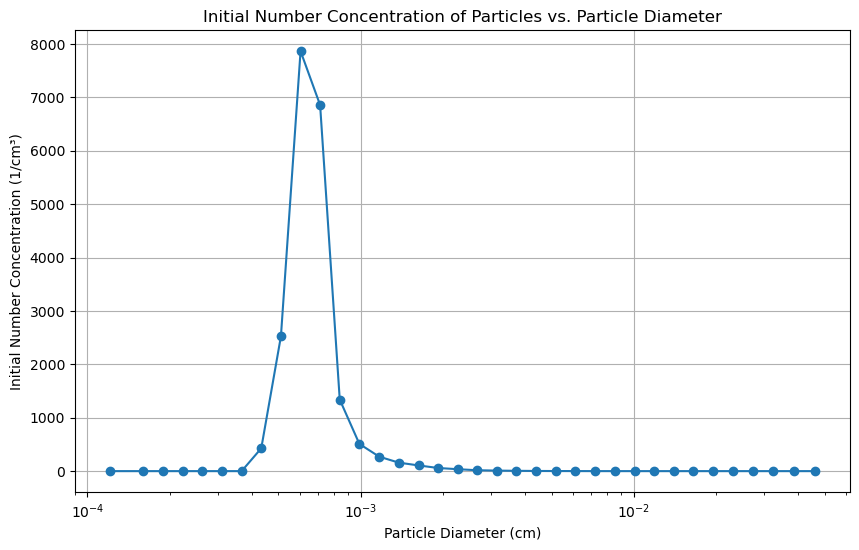

In [13]:
InitialConcentrationPlot(median_diameters, Number_Concentration, logscalex = True)

In [20]:
# Solve the system of ODEs using the SCE algorithm
sol_df = SCE_Algorithm(masses, Number_Concentration, Kernel = "all", Type = "rec", t_span = (0,3600))

# Animated PSD
AnimatedPSD(sol_df, median_diameters, logscalex= True)

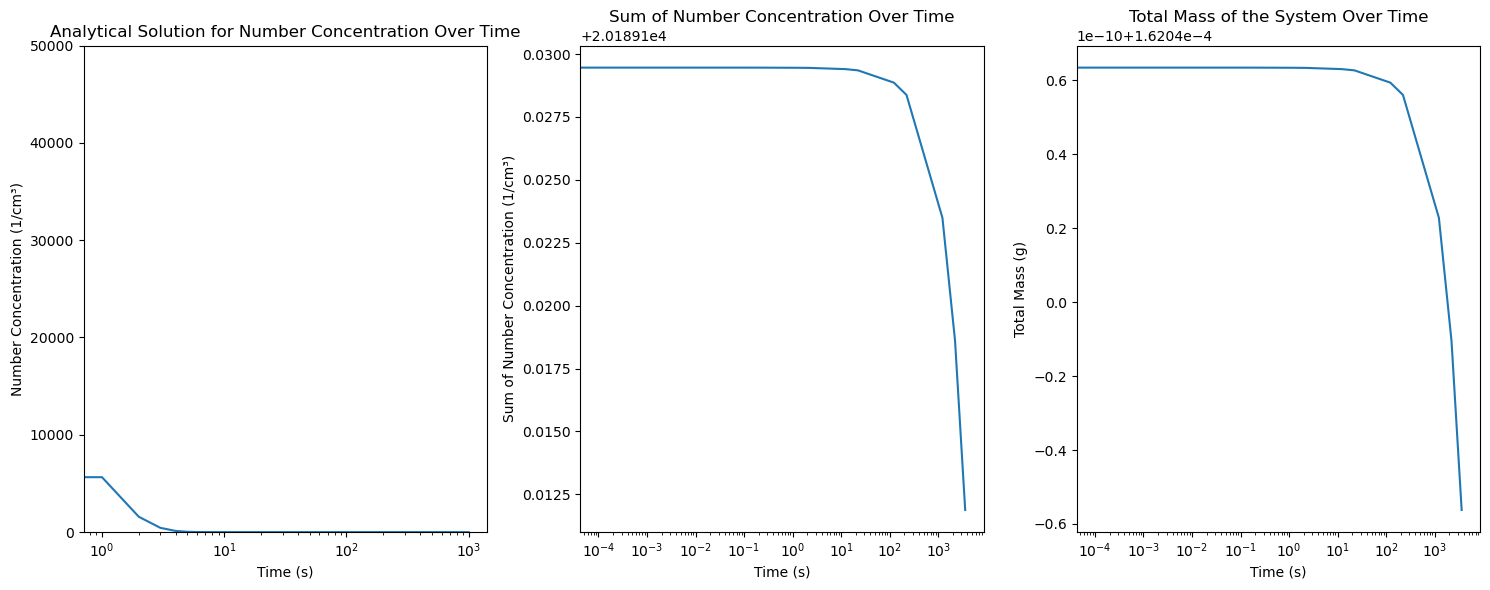

In [21]:
# Timeseries plots
Timeseriesplots(sol_df)

#### Normal Distribution Data

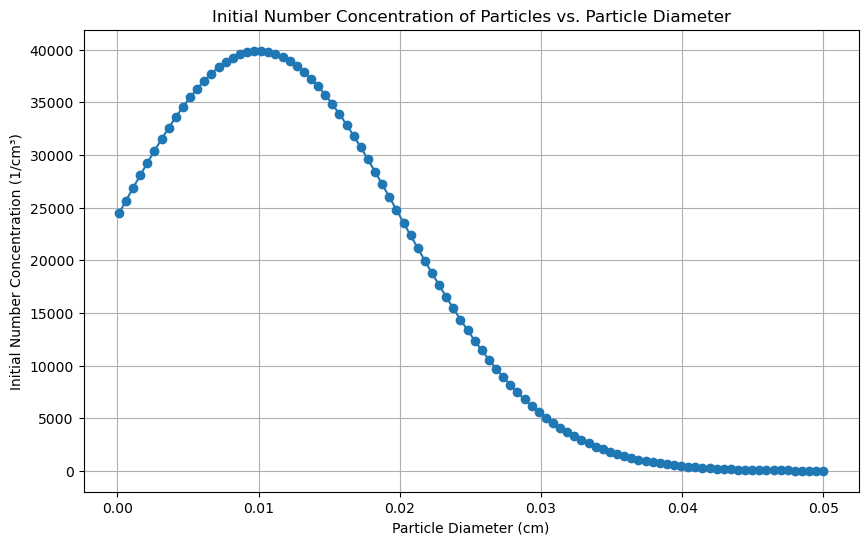

In [25]:
# Define a range of diameters of the particles.
diameters = generate_diameters(100, 1, 500, 'um') # 100 points between 1um and 500um

# Define the mass domain of the particles.
masses = generate_mass_domain(diameters)

#Define an initially normayl distributed PSD for the initial number concentrations of particles.

# Mean and standard deviation of the normal distribution.
mean = 100e-4 # Centered at 100um
std_dev = 100e-4 # Standard deviation of 100um

# Generate the initial number concentrations of particles using a normal distribution.
initial_concentrations = 1000 *  norm.pdf(diameters, mean, std_dev) # 250 points between 1um and 500um

# Visualize the initial number concentrations of particles.
InitialConcentrationPlot(diameters, initial_concentrations, logscalex = False)

In [24]:
# Solve the system of ODEs using the SCE algorithm
sol_df = SCE_Algorithm(masses, initial_concentrations, Kernel = "all", Type = "rec", t_span = (0,3600))

# Animated PSD
AnimatedPSD(sol_df, diameters)

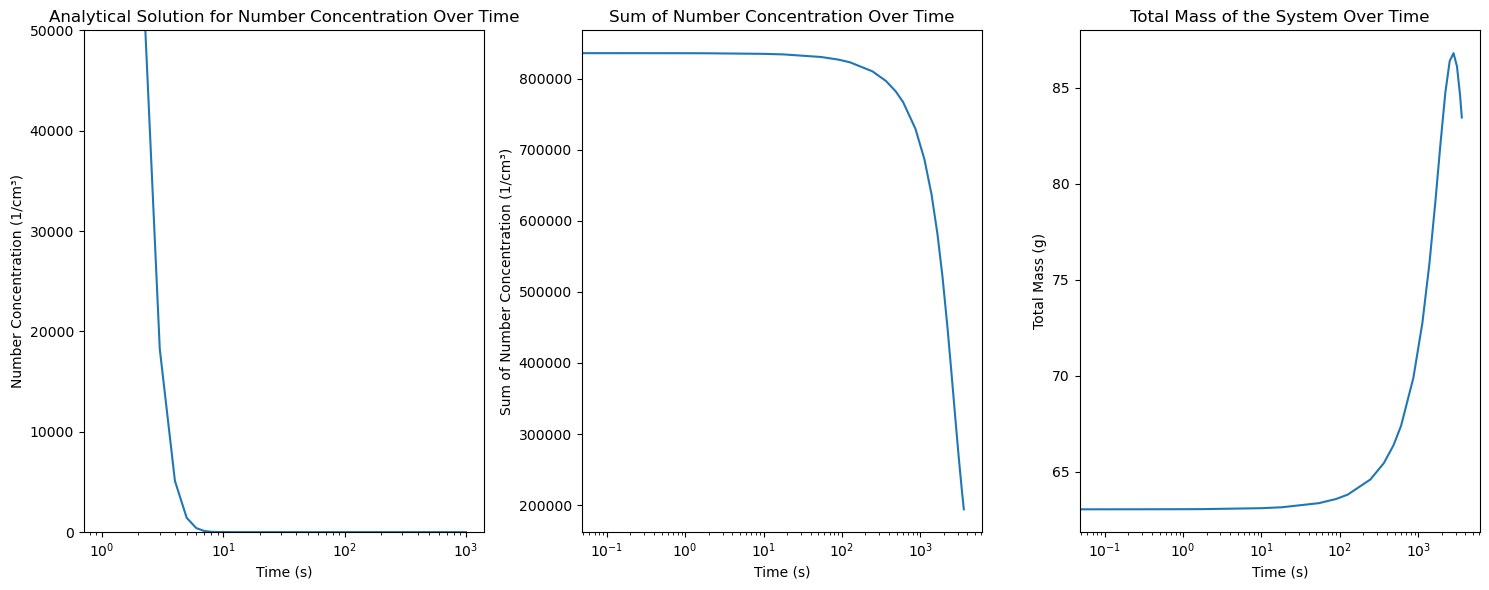

In [34]:
# Timeseries plots
Timeseriesplots(sol_df)

### A Trigonometric Distribution


50


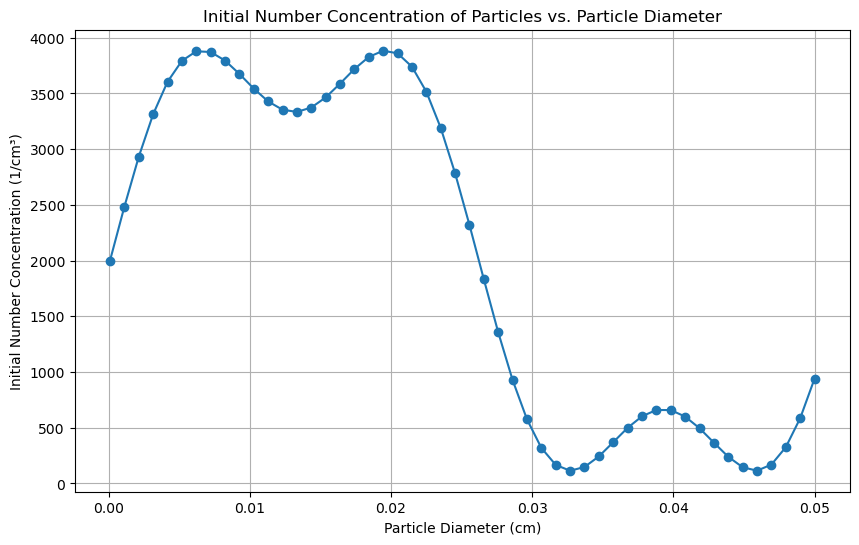

In [26]:
# Create a range of diameters
diameters = generate_diameters(50, 1, 500, 'um') # 50 points between 1um and 500um

# Create the mass domain
masses = generate_mass_domain(diameters)

# Define a function to generate the initial number concentrations of particles using a sine function.
def y(x):
    return (np.sin(x) + np.sin(3 * x) / 3 + 1) * 2000

Initial_Concentrations = y(np.linspace(0, 6, 50))
print(len(Initial_Concentrations))

# Visualize the initial number concentrations of particles.
InitialConcentrationPlot(diameters, Initial_Concentrations, logscalex = False)

In [27]:
# Solve the system of ODEs using the SCE algorithm
sol_df = SCE_Algorithm(masses, Initial_Concentrations, Kernel = "all", Type = "rec", t_span = (0,3600))

# Animated PSD
AnimatedPSD(sol_df, diameters)

C:\Users\trivi\AppData\Local\Temp\ipykernel_23160\1091435506.py:23: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  gain_integral = integrate.quad(


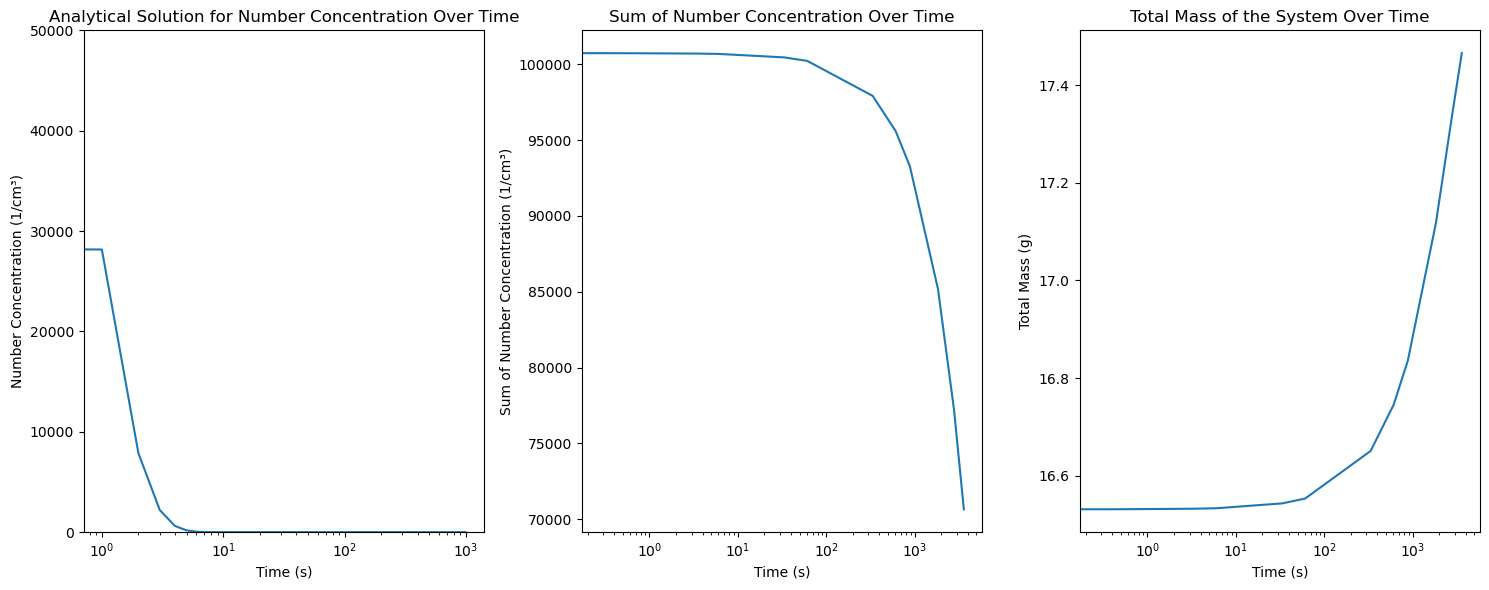

In [28]:
# Timeseries plots
Timeseriesplots(sol_df)

### A Constant Distribution

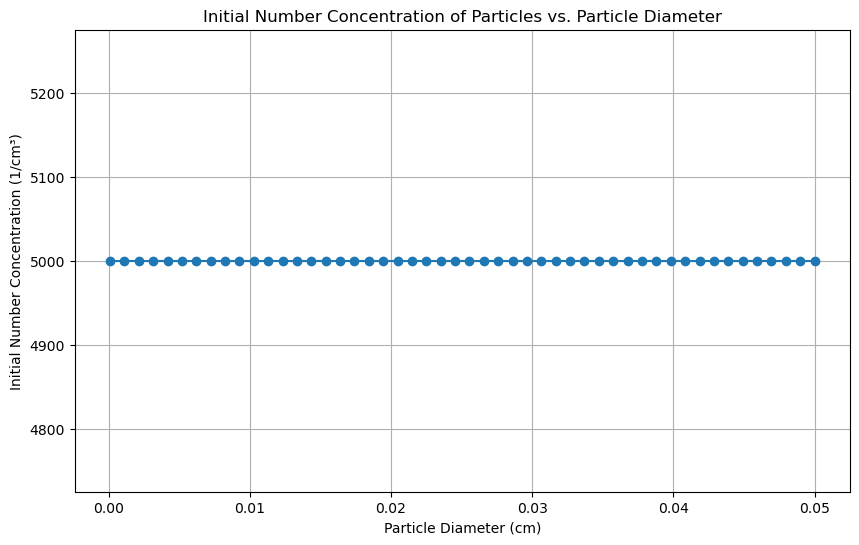

In [29]:
# Generate the particle diameters
diameters = generate_diameters(50, 1, 500, 'um') # 50 points between 1um and 500um

# Generate the mass domain
masses = generate_mass_domain(diameters)

# Define the constant initial number concentrations of particles
Initial_Concentrations = np.ones_like(diameters) * 5000

# Visualize the initial number concentrations of particles.
InitialConcentrationPlot(diameters, Initial_Concentrations, logscalex = False)

In [30]:
# Solve the system of ODEs using the SCE algorithm
sol_df = SCE_Algorithm(masses, Initial_Concentrations, Kernel = "all", Type = "rec", t_span = (0,3600))

# Animated PSD
AnimatedPSD(sol_df, diameters)

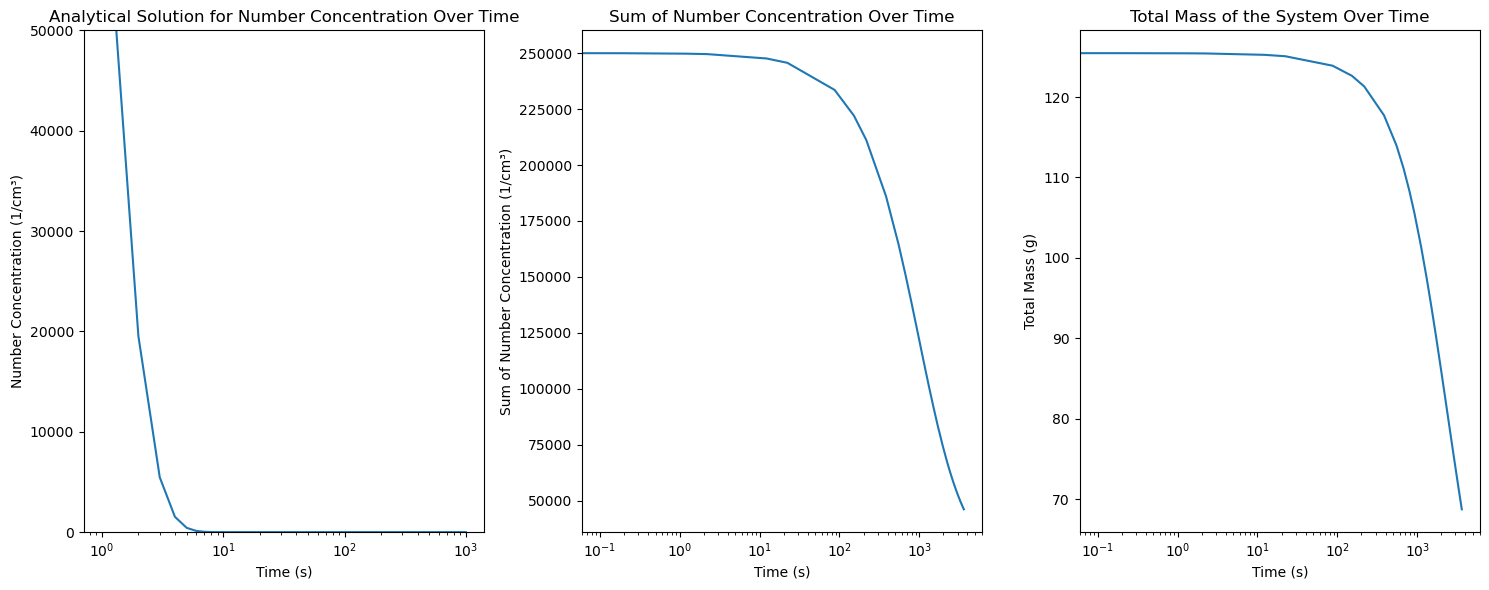

In [31]:
# Timeseries plots
Timeseriesplots(sol_df)

### A Linear Distribution

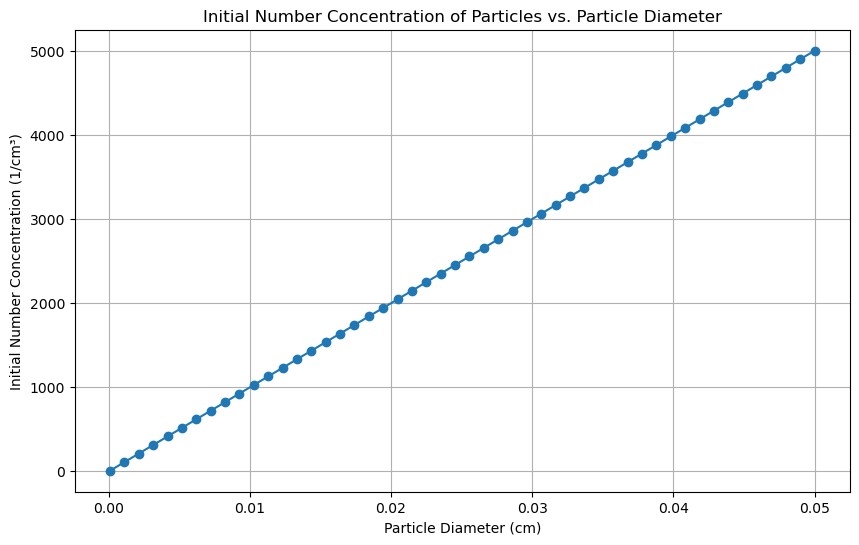

In [33]:
# Generate the particle diameters
diameters = generate_diameters(50, 1, 500, 'um') # 50 points between 1um and 500um

# Generate the mass domain
masses = generate_mass_domain(diameters)

# Define a linear initial number concentrations of particles.
def y(x):
    return x

# Define the linear initial number concentrations of particles
Initial_Concentrations = y(np.linspace(0, 5000, 50))

# Visualize the initial number concentrations of particles.
InitialConcentrationPlot(diameters, Initial_Concentrations, logscalex = False)


In [34]:
# Solve the system of ODEs using the SCE algorithm
sol_df = SCE_Algorithm(masses, Initial_Concentrations, Kernel = "all", Type = "rec", t_span = (0,3600))

# Animated PSD
AnimatedPSD(sol_df, diameters)

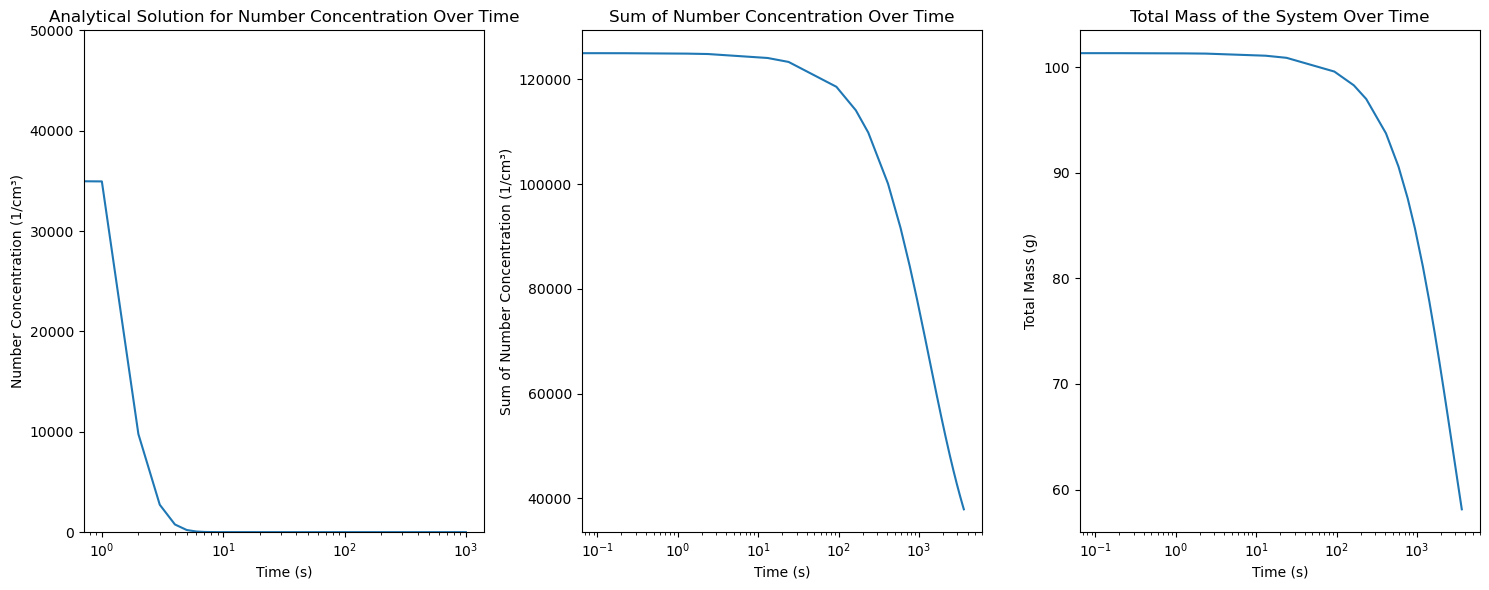

In [35]:
# Timeseries plots
Timeseriesplots(sol_df)